In [53]:
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as kbck

from IPython.display import Image, HTML 
from PIL import Image, ImageDraw

import sys
import os

#sys.path.append(os.path.join('D:/', 'Max', 'python', 'randimg'))
sys.path.append(os.getcwd())

import itertools
import ImgGenerator

tf.keras.backend.clear_session()  # For easy reset of notebook state.

in1 = keras.Input(shape=( ImgGenerator.H, ImgGenerator.W//2, 2), name='inp1')
in_r1 = layers.Reshape((ImgGenerator.H, ImgGenerator.W), name="reshaped_input")(in1)

lstm =layers.LSTM(units=256*4, name="lstm")(in_r1) 
lstm=layers.Reshape((128,8), name="reshaped_lstm")(lstm)
print(lstm)

in_conv = layers.DepthwiseConv2D((128,1), padding="same", data_format='channels_last', name="depth-conv")(in1)
print(in_conv)
in_conv = layers.Reshape((128,128), name="reshape_conv")(in_conv)

rnn = layers.SimpleRNN(256, name="rnn")(in_r1)
rnn=layers.Reshape((128,2), name="reshaped_rnn")(rnn)
print(rnn)

# Rotated
rot_layer = layers.Lambda(lambda x: kbck.reverse(x,axes=0),output_shape=(64, 128, 2 ))(in1)
rot_layer = layers.Reshape((ImgGenerator.H, ImgGenerator.W), name="reshaped_input2")(rot_layer)
in_conv2 = layers.SimpleRNN(128, name="rnn2")(rot_layer)
print(in_conv2)
in_conv2 = layers.Reshape((128,1), name="reshape_conv2")(in_conv2)



d0 = layers.Dense(1024, activation="tanh", name="dense-inp")(in_r1)#
print(d0)

d0 = layers.Concatenate(axis=2)([d0,lstm,in_conv, rnn, in_conv2])
print(d0.shape)
rnn = layers.Flatten()(d0)
#rnn = layers.BatchNormalization(momentum=0.8)(rnn)
#rnn = layers.LeakyReLU()(rnn)
print(rnn)
dense_1 = layers.Dense(2048, activation="relu")(rnn)#, activation="relu"
#dense_1 = layers.BatchNormalization(momentum=0.8)(dense_1)
#dense_1 = layers.LeakyReLU()(dense_1)
print(dense_1)
#for layer_idx in range(0, 5):
#    dense_1 = layers.BatchNormalization(momentum=0.8)(dense_1)
#    dense_1 = layers.Dense(1024, activation="tanh", name=f"muldence{layer_idx}")(dense_1)#, activation="relu"
dense_2 = layers.Dense(4096, activation="relu")(dense_1)#, activation="relu"
#dense_2 = layers.BatchNormalization(momentum=0.8)(dense_2)
print(dense_2)

output = layers.Dense(128*128)(dense_2)#,, activation="softplus"
#output = layers.Softmax()(output)

print(f"Last dense:{output}")

output = layers.Reshape((128, 128))(output)
print(f"Out layer:{output}")


Tensor("reshaped_lstm/Identity:0", shape=(None, 128, 8), dtype=float32)
Tensor("depth-conv/Identity:0", shape=(None, 128, 64, 2), dtype=float32)
Tensor("reshaped_rnn/Identity:0", shape=(None, 128, 2), dtype=float32)
Tensor("rnn2/Identity:0", shape=(None, 128), dtype=float32)
Tensor("dense-inp/Identity:0", shape=(None, 128, 1024), dtype=float32)
(None, 128, 1163)
Tensor("flatten/Identity:0", shape=(None, 148864), dtype=float32)
Tensor("dense/Identity:0", shape=(None, 2048), dtype=float32)
Tensor("dense_1/Identity:0", shape=(None, 4096), dtype=float32)
Last dense:Tensor("dense_2/Identity:0", shape=(None, 16384), dtype=float32)
Out layer:Tensor("reshape/Identity:0", shape=(None, 128, 128), dtype=float32)


In [54]:
model = keras.Model(inputs=in1, outputs=output)
#model = keras.Model(inputs=x, outputs=output)
model.summary()
model.compile(optimizer="Adam", loss="mse", metrics=["acc"])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 128, 64, 2)] 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 64, 2)   0           inp1[0][0]                       
__________________________________________________________________________________________________
reshaped_input (Reshape)        (None, 128, 128)     0           inp1[0][0]                       
__________________________________________________________________________________________________
reshaped_input2 (Reshape)       (None, 128, 128)     0           lambda[0][0]                     
______________________________________________________________________________________________

In [55]:
Xnor = 127.
Ynor = 255.
N = 40
#train_x = np.random.randint(0, high=10, size=(32, 128, 128, ))
"""
train_x =np.random.randint(0, high=10, size=(32, 128, 128))
         
train_y = np.random.randint(0, high=1, size=(32, 128, 128))
"""

train_x, train_y = ([],[])
for x,y in itertools.islice( ImgGenerator.gen_numpy_2chanel_sample(), 0, N+30 ):
    train_x.append(x/Xnor) #train_x.append(np.expand_dims(x, 0))
    train_y.append(y/Ynor) #
train_x = np.stack(train_x)
train_y = np.stack(train_y)

print(f"Shape of train_x:{train_x.shape}, train_y:{train_y.shape}")
#print(f"Shape of train_x:{train_x[0].shape}, train_y:{train_y[0].shape}")

history = model.fit(train_x, train_y, epochs=N)


Shape of train_x:(70, 128, 64, 2), train_y:(70, 128, 128)
Epoch 1/40
3/3 [==============================] - 7s 2s/step - loss: 0.6863 - acc: 0.0372
Epoch 2/40
3/3 [==============================] - 8s 3s/step - loss: 0.5126 - acc: 0.0562
Epoch 3/40
3/3 [==============================] - 8s 3s/step - loss: 0.4758 - acc: 0.0455
Epoch 4/40
3/3 [==============================] - 9s 3s/step - loss: 0.4498 - acc: 0.1102
Epoch 5/40
3/3 [==============================] - 8s 3s/step - loss: 0.3276 - acc: 0.2021
Epoch 6/40
3/3 [==============================] - 9s 3s/step - loss: 0.2663 - acc: 0.1564
Epoch 7/40
3/3 [==============================] - 9s 3s/step - loss: 0.2182 - acc: 0.2057
Epoch 8/40
3/3 [==============================] - 9s 3s/step - loss: 0.1982 - acc: 0.2890
Epoch 9/40
3/3 [==============================] - 9s 3s/step - loss: 0.1862 - acc: 0.1569
Epoch 10/40
3/3 [==============================] - 9s 3s/step - loss: 0.1751 - acc: 0.1897
Epoch 11/40
3/3 [========================

In [56]:
#
# model evaluation
test_x = []
test_y = []
T = 20
# make test set
for x, y in itertools.islice(ImgGenerator.gen_numpy_2chanel_sample(), 0, T):
    test_x.append(x/Xnor)
    test_y.append(y/Ynor)

test_x = np.stack(test_x)
test_y = np.stack(test_y) # convert from list to np.array

print(f'Test: x: shape:{test_x.shape}, max:{np.amax(test_x)} ; y: shape:{test_y.shape} max:{np.amax(test_y)}')

test_scores = model.evaluate(test_x, test_y, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])


Test: x: shape:(20, 128, 64, 2), max:1.0078740119934082 ; y: shape:(20, 128, 128) max:1.0
1/1 - 0s - loss: 0.2064 - acc: 0.0465
Test loss: 0.20643790066242218
Test accuracy: 0.04648437350988388


In [57]:
#target_y, predict_in = zip(
#    *[(y, x) for x, y in itertools.islice(ImgGenerator.gen_numpy_2chanel_sample(), 0,4)] )
print(test_x.shape)
#predict_in = np.stack(predict_in)
predict_in = test_x
prediction = model.predict(predict_in)
print(prediction.shape)

(20, 128, 64, 2)
(20, 128, 128)


In [58]:
amax = np.amax(prediction)
print(f"Max item = {amax}, mean={np.mean(prediction)}")
#prediction= (prediction/amax)
#prediction[prediction > 1.]= 1.
#prediction[prediction < 0]= 0
for v in prediction:
    print(f"Sample:{v[43,17]}, max:{np.amax(v)}, min:{np.amin(v)}")

Max item = 1.3352481126785278, mean=0.47517186403274536
Sample:0.05360714718699455, max:1.137540340423584, min:-0.3104228377342224
Sample:0.3012113869190216, max:0.9355920553207397, min:-0.10028856992721558
Sample:0.18234379589557648, max:1.0260553359985352, min:-0.17554476857185364
Sample:0.8411856293678284, max:1.1630096435546875, min:-0.12743625044822693
Sample:0.5236350297927856, max:1.2370944023132324, min:-0.309449702501297
Sample:0.15998968482017517, max:1.0758863687515259, min:-0.29069647192955017
Sample:0.8031185269355774, max:1.1179661750793457, min:-0.11694007366895676
Sample:0.1291954517364502, max:0.822435736656189, min:-0.2464897632598877
Sample:0.4438507854938507, max:0.7884116172790527, min:-0.1546148806810379
Sample:0.05651554837822914, max:0.8779100775718689, min:-0.2863359749317169
Sample:0.709570586681366, max:1.162806749343872, min:-0.17211204767227173
Sample:0.6818718910217285, max:1.3219202756881714, min:-0.18111751973628998
Sample:1.0043679475784302, max:1.33524

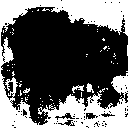

In [59]:
v=prediction[0]
iv = Image.fromarray( ((v > 0.6).astype(np.int)*255).astype(np.uint8), 'L')
display(iv)

Source Max item=1.0, source-shape:(20, 128, 128), predictions-shape:(20, 128, 128)
Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean116.7831802368164


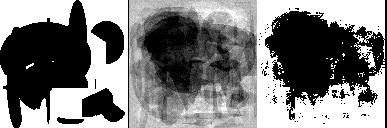

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean113.23001098632812


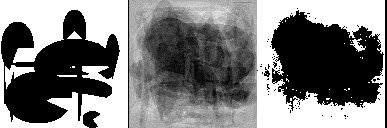

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean116.57328033447266


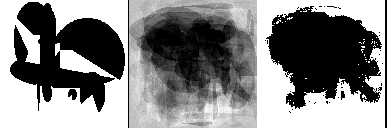

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean160.9449462890625


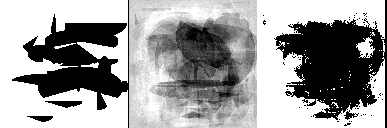

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean112.90174865722656


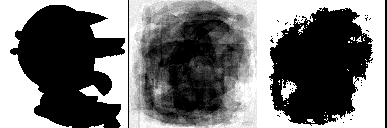

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean104.95248413085938


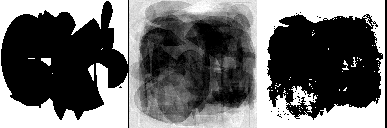

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean158.60475158691406


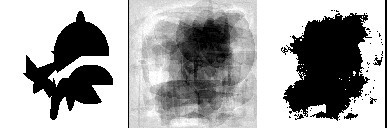

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean72.20912170410156


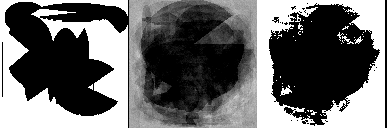

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean91.84458923339844


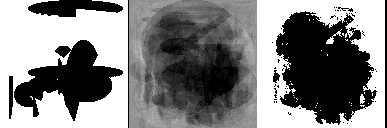

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean84.15065002441406


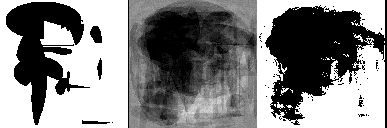

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean142.64862060546875


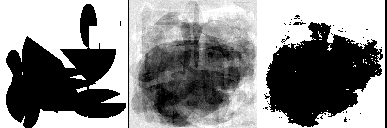

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean163.318359375


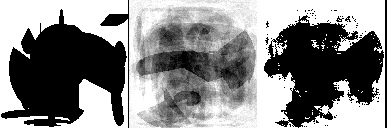

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean142.3043670654297


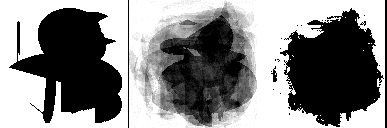

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean156.93186950683594


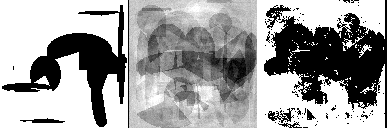

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean125.69221496582031


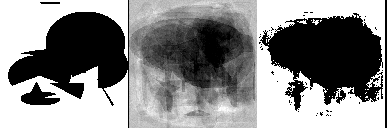

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean83.65233612060547


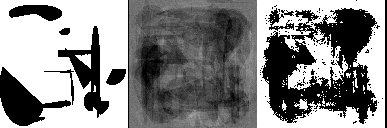

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean141.10755920410156


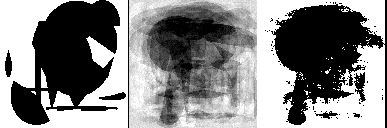

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean100.76387023925781


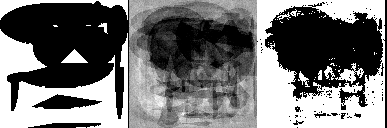

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean139.98638916015625


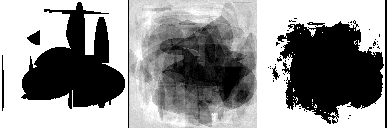

Source item-max=255, source-shape:(128, 128), predictions: shape:(128, 128) :mean94.77618408203125


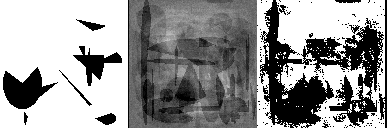

In [60]:
print(f"Source Max item={np.amax(test_y)}, source-shape:{test_y.shape}, predictions-shape:{prediction.shape}")
# ix = Image.fromarray((target_y[0]*255).astype(np.int8), 'L') 

for p, y in zip((prediction * Ynor), (test_y*Ynor).astype(np.uint8)):
    p_mean = p.mean()
    print(f"Source item-max={np.amax(y)}, source-shape:{y.shape}, predictions: shape:{p.shape} :mean{p_mean}")
    iy = Image.fromarray(y, 'L')
    p_grey = p
    p_grey[p_grey > 255.] = 255.
    p_grey[p_grey < 0] = 0.
    p_grey = p_grey.astype(np.uint8)
    ip = Image.fromarray(p_grey, 'L')
    ip_bw = Image.fromarray( ((p > p_mean).astype(np.int)*255).astype(np.uint8), 'L')

    tub = Image.new("RGB", (ImgGenerator.W*3 + 3, ImgGenerator.H))
    tub.paste(iy, (0, 0, ImgGenerator.W, ImgGenerator.H))
    tub.paste(ip, (ImgGenerator.W+1, 0))
    tub.paste(ip_bw, (ImgGenerator.W*2+1, 0))
    
    display(tub)
        